In [84]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# to enable imports from parent package
import sys
import os
from pathlib import Path
parent_dir = Path(os. getcwd()).parent.absolute()
sys.path.append(str(parent_dir))

import torch
import numpy as np
import os.path as osp
import pandas as pd
import seaborn as sns

from attacks.data_recorder import compute_regression_metrics
from plots import aggregate_over_splits, remove_unused_categories, palette, model_types, group, remove_top_percentage, groupby_to_table, rename_col, concatenate, append_model_type, compute_baseline_score

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Liberation Sans']})
import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt



device = ('cuda' if torch.cuda.is_available() else
          'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}')


plots_dir = 'output'
dataset_name = "ZINC12k"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cuda


In [85]:
from tqdm import tqdm
from run_attacks import all_tasks

results_directory = '../results/'

# tasks_to_load = ["original", "bruteforce"]
# filter_tasks = lambda tasks: {task: val for task, val in tasks.items() if any(t in task for t in tasks_to_load)}
# attack_tasks = {model_name: filter_tasks(val) for model_name, val in all_tasks.items()}

# attack_tasks = all_tasks

def load_data(all_tasks, dataset_name, tasks_to_load=[], sortby=["model", "task", "id"], apply_transform=None):
    data = []

    if tasks_to_load:
        filter_tasks = lambda tasks: {task: val for task, val in tasks.items() if any(t in task for t in tasks_to_load)}
        all_tasks = {model_name: filter_tasks(val) for model_name, val in all_tasks.items() if dataset_name in model_name}

    for model_name, tasks in tqdm(all_tasks.items()):
        # if not dataset_name in model_name:
        #     continue
        model_type = model_name.split("_")[0]
        dataset = model_name.split("_")[1]

        for task_name, task in tasks.items():
            path = osp.join(results_directory, dataset, model_name, f"{task_name}.data")
            if not osp.exists(path):
                continue

            df = pd.read_pickle(path)
            if apply_transform is not None:
                    df = apply_transform(df)
            data.append(df)
            # try:
            #     df = pd.read_pickle(path)
            #     if apply_transform is not None:
            #          df = apply_transform(df)
            #     data.append(df)
            # except Exception as e:
            #     print(f"ERROR when reading task '{task_name}' of '{model_name}'")
            #     print(e)

    def short_model_names_map(df, prefix_len=1):
        model_names = set(df["model"].values)
        count = {}
        rename_map = {}
        for model_name in model_names:
            prefix = "_".join(model_name.split("_")[:prefix_len])
            if not prefix in count:
                count[prefix] = 0
            rename_map[model_name] = f"{prefix}_{count[prefix]}"
            count[prefix] += 1
        return rename_map

    data = concatenate(data)
    data.sort_values(sortby, inplace=True)
    data = data.reset_index(drop=True)
    model_name_map = short_model_names_map(data)
    data["model"] = data["model"].cat.rename_categories(model_name_map)
    append_model_type(data)
    data["model_rep"] = [int(x[-1]) for x in data["model"]]
    data = data[~data["id"].isna()]
    data["id"] = data["id"].astype("int32")

    if (data["is_undirected"] == 0).any():
        mask = data["is_undirected"] == 0
        print("found directed perturbation")
        print(data[mask])
    # assert (data["is_undirected"] == 1).all()

    return data


## Original Data

In [86]:
orig_data = load_data(all_tasks, "ZINC12k", ["original"])

def remove_duplicates(data, unit_ident=["model", "task", "id"]):
    data["timestamp"] = data["timestamp"].astype(str) + np.random.rand(len(data)).astype(str)
    idx = data.groupby(unit_ident)['timestamp'].transform(max) == data['timestamp']
    data = data[idx]
    data.sort_values(unit_ident, inplace=True)
    return data

orig_data = remove_duplicates(orig_data)

# normalize
some_model = list(orig_data["model"])[0]
ys = np.array(orig_data[(orig_data["model"]==some_model) & (orig_data["task"]=="original")]["y"])
y_mean, y_std = ys.mean(), ys.std()
print(f"mean {y_mean}, std {y_std}")
orig_data["norm_y"] = (orig_data["y"] - y_mean) / y_std
orig_data["norm_pred"] = (orig_data["pred"] - y_mean) / y_std
compute_regression_metrics(orig_data, y_col="norm_y", pred_col="norm_pred", mae_col="norm_mae")

pd.pivot_table(orig_data[["model_type", "y"]], columns="model_type", aggfunc="count")

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 256.89it/s]


mean 0.01241438090801239, std 2.017002582550049


model_type,Baseline,DropGINE,ESAN,GIN,GINE,PPGN,SignNet,meanGINE
y,5000,5000,5000,5000,5000,5000,5000,5000


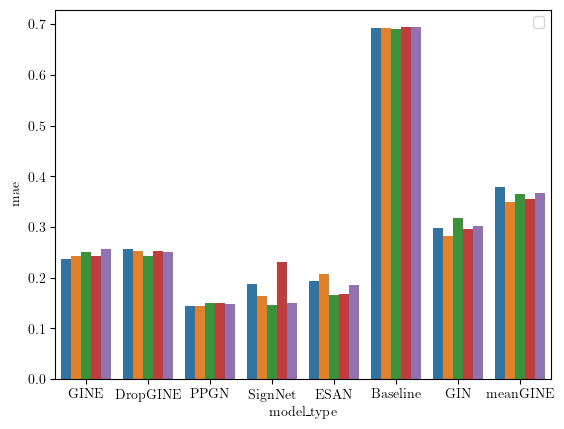

,model_type,mae,norm_mae
0,Baseline,$0.692 \pm 0.002$,$0.343 \pm 0.001$
1,DropGINE,$0.251 \pm 0.005$,$0.124 \pm 0.003$
2,ESAN,$0.184 \pm 0.018$,$0.091 \pm 0.009$
3,GIN,$0.299 \pm 0.013$,$0.148 \pm 0.007$
4,GINE,$0.246 \pm 0.008$,$0.122 \pm 0.004$
5,PPGN,$0.147 \pm 0.003$,$0.073 \pm 0.001$
6,SignNet,$0.176 \pm 0.035$,$0.087 \pm 0.017$
7,meanGINE,$0.363 \pm 0.011$,$0.18 \pm 0.005$


In [87]:
orig_per_model = group(orig_data, ["model"]).mean().reset_index()
append_model_type(orig_per_model)
orig_per_model["budget"] = 0
orig_per_model["norm_mae_"] = orig_per_model["norm_mae"]

plot = sns.barplot(data=orig_per_model, x="model_type", y="mae", hue="model_rep")
plot.legend([])
plt.show()

groupby_to_table(orig_per_model[["model_type", "mae", "norm_mae"]].groupby("model_type"))

## Bruteforce Data

In [88]:
cycle_count = orig_data[(orig_data["model"]==some_model)][["id", "num_large_cycles"]]
cycle_count = cycle_count.rename(columns={"num_large_cycles": "orig_num_large_cycles"})

def recompute_label(df):
    merged = df.merge(cycle_count, on="id")
    merged["y_"] = merged["y"] + merged["orig_num_large_cycles"] - merged["num_large_cycles"]
    compute_regression_metrics(merged, y_col="y_", pred_col="pred", mae_col="mae_")
    return merged

In [89]:
# norm & norm the data
bf_data = load_data(all_tasks, "ZINC12k", ["bruteforce"])

# remove duplicates
# bf_data["timestamp"] = bf_data["timestamp"].astype(str) + np.random.rand(len(bf_data)).astype(str)
# idx = bf_data.groupby(["model", "task", "id", "perturbation"])['timestamp'].transform(max) == bf_data['timestamp']
# bf_data = bf_data[idx]
# bf_data.sort_values(["model", "task", "id", "perturbation"], inplace=True)
bf_data = bf_data.drop_duplicates(subset=["model", "task", "id", "perturbation"])


bf_data["norm_y"] = (bf_data["y"] - y_mean) / y_std
bf_data["norm_pred"] = (bf_data["pred"] - y_mean) / y_std
compute_regression_metrics(bf_data, y_col="norm_y", pred_col="norm_pred", mae_col="norm_mae")

bf_data = recompute_label(bf_data)
bf_data["norm_y_"] = (bf_data["y_"] - y_mean) / y_std
compute_regression_metrics(bf_data, y_col="norm_y_", pred_col="norm_pred", mae_col="norm_mae_")

pd.pivot_table(bf_data, index=["task", "perturbation"], columns="model_type", aggfunc="count")["y"] # should be 5000 everywhere

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 776.28it/s]


model_type                        DropGINE  ESAN   GIN  GINE  PPGN  SignNet  \
task            perturbation                                                  
bruteforce_incr add-edge              5000  5000  5000  5000  5000     5000   
                drop-edge             5000  5000  5000  5000  5000     5000   
                modify-edge-attr      5000  5000     0  5000  5000     5000   
                modify-node-attr      5000  5000  5000  5000  5000     5000   
bruteforce_decr add-edge              5000  5000  5000  5000  5000     5000   
                drop-edge             5000  5000  5000  5000  5000     5000   
                modify-edge-attr      5000  5000     0  5000  5000     5000   
                modify-node-attr      5000  5000  5000  5000  5000     5000   

model_type                        meanGINE  
task            perturbation                
bruteforce_incr add-edge              5000  
                drop-edge             5000  
                modify-edge-attr      5000  
                modify-node-attr      5000  
bruteforce_decr add-edge              5000  
                drop-edge             5000  
                modify-edge-attr      5000  
                modify-node-attr      5000

,model_type,norm_mae,delta_norm_mae,recomp_norm_mae,delta_recomp_norm_mae
0,DropGINE,$1.487 \pm 0.082$,$1.363 \pm 0.084$,$2.055 \pm 0.057$,$1.931 \pm 0.06$
1,ESAN,$1.862 \pm 0.445$,$1.77 \pm 0.45$,$1.947 \pm 0.366$,$1.855 \pm 0.37$
2,GIN,$2.76 \pm 0.116$,$2.612 \pm 0.119$,$2.874 \pm 0.108$,$2.726 \pm 0.112$
3,GINE,$1.529 \pm 0.118$,$1.407 \pm 0.118$,$2.027 \pm 0.076$,$1.905 \pm 0.075$
4,PPGN,$1.721 \pm 0.2$,$1.648 \pm 0.202$,$1.729 \pm 0.16$,$1.656 \pm 0.162$
5,SignNet,$2.144 \pm 0.487$,$2.056 \pm 0.501$,$1.869 \pm 0.27$,$1.782 \pm 0.269$
6,meanGINE,$1.139 \pm 0.132$,$0.959 \pm 0.134$,$1.832 \pm 0.07$,$1.652 \pm 0.069$


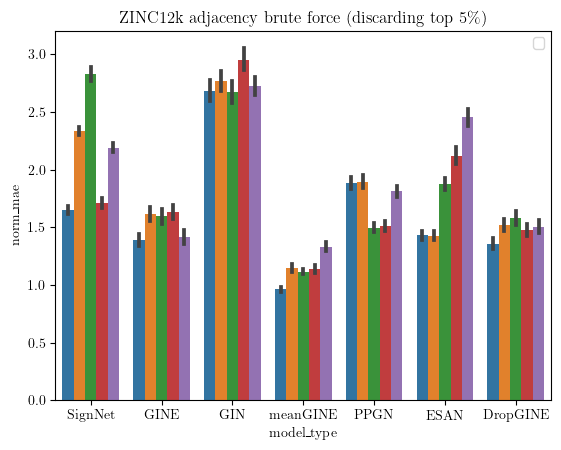

In [90]:
## ADJACENCY PERTURBATION

# aggregate over adj perturbations and tasks
adjbf_data = remove_unused_categories(bf_data[bf_data["perturbation"].isin(["add-edge", "drop-edge"])])

task_agg_df = aggregate_over_splits(adjbf_data, group_by=adjbf_data["task"], shared_cols=["model", "id", "perturbation"], target_col="norm_mae")
adjbf_agg = aggregate_over_splits(task_agg_df, group_by=task_agg_df["perturbation"], shared_cols=["model", "id"], target_col="norm_mae")
adjbf_agg["task_type"] = "adj_bf"
adjbf_agg = remove_top_percentage(adjbf_agg, 0.05, ["mae", "norm_mae"], groupby=adjbf_agg["model"])

plot = sns.barplot(data=adjbf_agg, x="model_type", y="norm_mae", hue="model_rep")
plot.legend([])
plt.title("ZINC12k adjacency brute force (discarding top 5\%)")
# plot.figure.savefig(osp.join(plots_dir, "ZINC12k_adjBF_max.png"), dpi=450, bbox_inches='tight')

per_model = group(adjbf_agg, ["model"]).mean().reset_index()
append_model_type(per_model)
per_model = per_model.merge(orig_per_model[["model", "mae", "norm_mae"]].rename(columns={'mae': 'orig_mae', 'norm_mae': 'orig_norm_mae'}), on="model")
per_model["delta_mae"] = per_model["mae"] - per_model["orig_mae"]
per_model["delta_norm_mae"] = per_model["norm_mae"] - per_model["orig_norm_mae"]


## RECOMPUTED LABEL
task_agg_recomp_df = aggregate_over_splits(adjbf_data, group_by=adjbf_data["task"], shared_cols=["model", "id", "perturbation"], target_col="norm_mae_")
adjbf_agg_recomp = aggregate_over_splits(task_agg_recomp_df, group_by=task_agg_recomp_df["perturbation"], shared_cols=["model", "id"], target_col="norm_mae_")
adjbf_agg_recomp["task_type"] = "adj_bf"
adjbf_agg_recomp = remove_top_percentage(adjbf_agg_recomp, 0.05, ["mae_", "norm_mae_"], groupby=adjbf_agg_recomp["model"])

recomp_per_model = group(adjbf_agg_recomp, ["model"]).mean().reset_index()
append_model_type(recomp_per_model)
recomp_per_model = recomp_per_model.merge(orig_per_model[["model", "mae", "norm_mae"]].rename(columns={'mae': 'orig_mae', 'norm_mae': 'orig_norm_mae'}), on="model")
recomp_per_model = recomp_per_model.rename(columns={"mae_": "recomp_mae", "norm_mae_": "recomp_norm_mae"})
recomp_per_model["delta_recomp_mae"] = recomp_per_model["recomp_mae"] - recomp_per_model["orig_mae"]
recomp_per_model["delta_recomp_norm_mae"] = recomp_per_model["recomp_norm_mae"] - recomp_per_model["orig_norm_mae"]
recomp_per_model = recomp_per_model[["model", "recomp_mae", "delta_recomp_mae", "recomp_norm_mae", "delta_recomp_norm_mae"]]

per_model = per_model.merge(recomp_per_model, on="model")

# groupby_to_table(per_model[["model_type", "mae", "delta_mae", "norm_mae", "delta_norm_mae"]].groupby("model_type"))
groupby_to_table(per_model[["model_type", "norm_mae", "delta_norm_mae", "recomp_norm_mae", "delta_recomp_norm_mae"]].groupby("model_type"))

In [91]:
# which combination of perturbation / task leads to strongest perturbation?
table = pd.pivot_table(adjbf_agg, index=["perturbation","task"], columns="model_type", aggfunc="count")["above_y"]/4750
table = table[["meanGINE", "GIN", "GINE", "SignNet", "DropGINE", "ESAN", "PPGN"]]
table.style.format('{:,.1%}'.format)

,model_type,norm_mae,delta_norm_mae,recomp_norm_mae,delta_recomp_norm_mae
0,DropGINE,$2.156 \pm 0.144$,$2.031 \pm 0.147$,$2.343 \pm 0.112$,$2.218 \pm 0.115$
1,ESAN,$2.323 \pm 0.309$,$2.232 \pm 0.314$,$2.276 \pm 0.252$,$2.184 \pm 0.256$
2,GINE,$2.325 \pm 0.203$,$2.203 \pm 0.201$,$2.49 \pm 0.197$,$2.368 \pm 0.195$
3,PPGN,$2.311 \pm 0.286$,$2.238 \pm 0.287$,$2.249 \pm 0.315$,$2.176 \pm 0.315$
4,SignNet,$2.418 \pm 0.623$,$2.33 \pm 0.636$,$2.285 \pm 0.531$,$2.198 \pm 0.54$
5,meanGINE,$2.477 \pm 0.528$,$2.297 \pm 0.532$,$2.654 \pm 0.512$,$2.474 \pm 0.517$


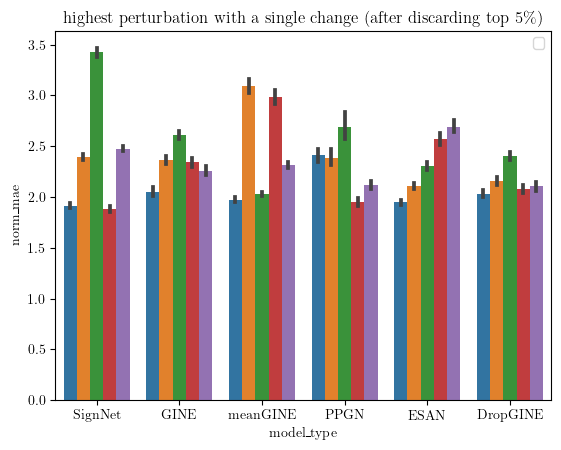

In [92]:
## ANY PERTURBATION
attrbf_data = bf_data.copy()
attrbf_data = remove_unused_categories(attrbf_data[attrbf_data["model_type"]!="GIN"]) # only include models with edge features

# combine adjacency perturbations
adj_pert = attrbf_data[attrbf_data["perturbation"].isin(["add-edge", "drop-edge"])]
adj_pert = aggregate_over_splits(adj_pert, group_by=adj_pert["perturbation"], shared_cols=["model", "id"], target_col="norm_mae")
attrbf_data = pd.concat(
    (attrbf_data[~attrbf_data["perturbation"].isin(["add-edge", "drop-edge"])],
     adj_pert))
pert = attrbf_data["perturbation"].astype(str)
pert[pert=="add-edge"] = "adjacency"
pert[pert=="drop-edge"] = "adjacency"
attrbf_data["perturbation"] = pert.astype("category")

attrbf_agg = aggregate_over_splits(attrbf_data, group_by=attrbf_data["task"], shared_cols=["model", "id", "perturbation"], target_col="norm_mae")
attrbf_agg = aggregate_over_splits(attrbf_agg, group_by=attrbf_agg["perturbation"], shared_cols=["model", "id"], target_col="norm_mae")
attrbf_agg["task_type"] = "bf"
attrbf_agg = remove_top_percentage(attrbf_agg, 0.05, ["mae", "norm_mae"], groupby=attrbf_agg["model"])

per_model = group(attrbf_agg, ["model"]).mean().reset_index()
append_model_type(per_model)
per_model = per_model.merge(orig_per_model[["model", "mae", "norm_mae"]].rename(columns={'mae': 'orig_mae', 'norm_mae': 'orig_norm_mae'}), on="model")
per_model["delta_mae"] = per_model["mae"] - per_model["orig_mae"]
per_model["delta_norm_mae"] = per_model["norm_mae"] - per_model["orig_norm_mae"]

## RECOMPUTED LABEL
task_agg_recomp_df = aggregate_over_splits(attrbf_data, group_by=attrbf_data["task"], shared_cols=["model", "id", "perturbation"], target_col="norm_mae_")
attrbf_agg_recomp = aggregate_over_splits(task_agg_recomp_df, group_by=task_agg_recomp_df["perturbation"], shared_cols=["model", "id"], target_col="norm_mae_")
attrbf_agg_recomp["task_type"] = "attr_bf"
attrbf_agg_recomp = remove_top_percentage(attrbf_agg_recomp, 0.05, ["mae_", "norm_mae_"], groupby=attrbf_agg_recomp["model"])

recomp_per_model = group(attrbf_agg_recomp, ["model"]).mean().reset_index()
append_model_type(recomp_per_model)
recomp_per_model = recomp_per_model.merge(orig_per_model[["model", "mae", "norm_mae"]].rename(columns={'mae': 'orig_mae', 'norm_mae': 'orig_norm_mae'}), on="model")
recomp_per_model = recomp_per_model.rename(columns={"mae_": "recomp_mae", "norm_mae_": "recomp_norm_mae"})
recomp_per_model["delta_recomp_mae"] = recomp_per_model["recomp_mae"] - recomp_per_model["orig_mae"]
recomp_per_model["delta_recomp_norm_mae"] = recomp_per_model["recomp_norm_mae"] - recomp_per_model["orig_norm_mae"]
recomp_per_model = recomp_per_model[["model", "recomp_mae", "delta_recomp_mae", "recomp_norm_mae", "delta_recomp_norm_mae"]]

per_model = per_model.merge(recomp_per_model, on="model")

plot = sns.barplot(data=attrbf_agg, x="model_type", y="norm_mae", hue="model_rep")
plot.legend([])
plt.title("highest perturbation with a single change (after discarding top 5\%)")
# plot.figure.savefig(osp.join(plots_dir, "ZINC12k_attrBF_max.png"), dpi=450, bbox_inches='tight')

groupby_to_table(per_model[["model_type", "norm_mae", "delta_norm_mae", "recomp_norm_mae", "delta_recomp_norm_mae"]].groupby("model_type"))

In [93]:
table = pd.pivot_table(attrbf_agg, index=["perturbation","task"], columns="model_type", aggfunc="count")["y"] / 4750
table = table[["meanGINE", "GINE", "SignNet", "DropGINE", "ESAN", "PPGN"]]
table.style.format('{:,.1%}'.format)

## Random Perturbations

In [94]:
baseline_data = orig_data[orig_data["model_type"]=="Baseline"]
baseline_value = baseline_data["norm_mae"].mean()
baseline_value

0.34329906

In [95]:
def reduce_data(df):
    df["norm_y"] = (df["y"] - y_mean) / y_std
    df["norm_pred"] = (df["pred"] - y_mean) / y_std
    compute_regression_metrics(df, y_col="norm_y", pred_col="norm_pred", mae_col="norm_mae")

    task = list(df["task"])[0]

    if "rel" in task and len(df)!=90000: # 18*5*1000
        model_name = list(df["model"])[0]
        print(f"{model_name} {task} - {len(df)}")
    elif "abs" in task and len(df)!=80000: # 16*5*1000
        model_name = list(df["model"])[0]
        print(f"{model_name} {task} - {len(df)}")

    df = df.reset_index()
    df_orig = remove_top_percentage(df.copy(), 0.05, ["mae", "norm_mae"], groupby=df["budget"])
    per_model_orig = group(df_orig, ["model", "task", "budget"]).mean().reset_index()

    df_recomputed = recompute_label(df.copy())
    df_recomputed["norm_y_"] = (df_recomputed["y_"] - y_mean) / y_std
    compute_regression_metrics(df_recomputed, y_col="norm_y_", pred_col="norm_pred", mae_col="norm_mae_")
    df_recomputed = remove_top_percentage(df_recomputed, 0.05, ["mae_", "norm_mae_"], groupby=df_recomputed["budget"])
    per_model_recomp = group(df_recomputed, ["model", "task", "budget"]).mean().reset_index()[["model", "task", "budget", "mae_", "norm_mae_"]]

    per_model = per_model_orig.merge(per_model_recomp, on=["model", "task", "budget"])
    append_model_type(per_model)

    return per_model

tasks = ["add_rdm_undir_edges", "drop_rdm_undir_edges", "rewire_rdm_undir_edges", "rdm_node_attr_change", "rdm_edge_attr_change"]
rdm_data = load_data(all_tasks, "ZINC12k", tasks, apply_transform=reduce_data, sortby=["model", "task"])
rdm_data.drop(columns="level_0", inplace=True)

  0%|          | 0/40 [00:00<?, ?it/s]

 12%|█▎        | 5/40 [00:09<01:04,  1.83s/it]

DropGINE_ZINC12k_300_5_0_20230722-215957 drop_rdm_undir_edges_abs - 70000


 15%|█▌        | 6/40 [00:10<01:01,  1.81s/it]

DropGINE_ZINC12k_300_5_1_20230722-232154 drop_rdm_undir_edges_abs - 70000


 18%|█▊        | 7/40 [00:12<00:59,  1.80s/it]

DropGINE_ZINC12k_300_5_2_20230723-005704 drop_rdm_undir_edges_abs - 70000


 20%|██        | 8/40 [00:14<00:57,  1.79s/it]

DropGINE_ZINC12k_300_5_3_20230723-023415 drop_rdm_undir_edges_abs - 70000


 22%|██▎       | 9/40 [00:16<00:55,  1.78s/it]

DropGINE_ZINC12k_300_5_4_20230723-035349 drop_rdm_undir_edges_abs - 70000


100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


,model_type,norm_mae
0,DropGINE,$0.971 \pm 0.056$
1,ESAN,$1.102 \pm 0.053$
2,GIN,$0.703 \pm 0.056$
3,GINE,$1.05 \pm 0.043$
4,PPGN,$1.288 \pm 0.023$
5,SignNet,$0.969 \pm 0.143$
6,meanGINE,$0.959 \pm 0.085$


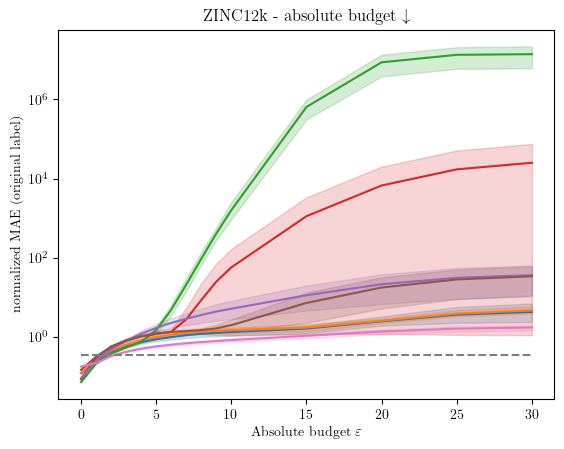

In [96]:
## ADJACENCY - ABS
adjrdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["add_rdm_undir_edges_abs", "drop_rdm_undir_edges_abs"])]).copy()
adjrdm_abs_data = adjrdm_abs_data[adjrdm_abs_data["budget"]<=30]
adjrmd_per_model = group(adjrdm_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(adjrmd_per_model)

adjrmd_per_model = pd.concat([adjrmd_per_model, orig_per_model]).reset_index()
adjrmd_per_model = remove_unused_categories(adjrmd_per_model[adjrmd_per_model["model_type"]!="Baseline"])
adjrmd_per_model = rename_col(adjrmd_per_model, "model_type", "model type")

plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="norm_mae", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (baseline_value, baseline_value), color='gray', linestyle="--")
plt.title("ZINC12k - absolute budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([i*5 for i in range(7)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('normalized MAE (original label)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_rdmadj_abs.pgf"), bbox_inches='tight')

AAB_orig_df = compute_baseline_score(adjrmd_per_model, baseline_value, "norm_mae", below=False)
AAB_orig_df["norm_mae"] = 100*AAB_orig_df["norm_mae"]
# AAB_recomp_df = compute_baseline_score(adjrmd_per_model, baseline_value, "norm_mae_", below=False)
# AAB_recomp_df["norm_mae_"] = 100*AAB_recomp_df["norm_mae_"]
# AAB_df = AAB_orig_df.merge(AAB_recomp_df[["model", "norm_mae_"]], on="model")
groupby_to_table(AAB_orig_df[["model_type", "norm_mae"]].groupby("model_type"))

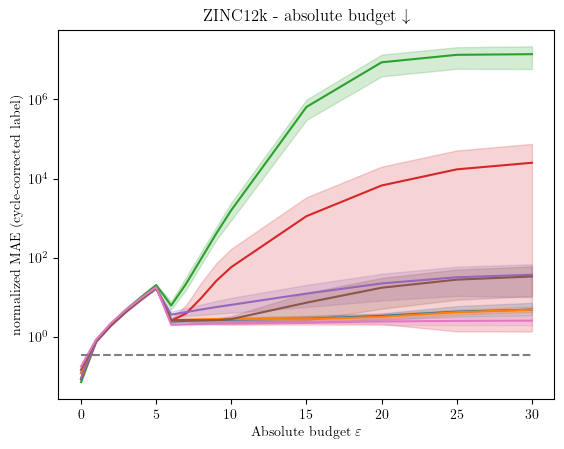

In [97]:
plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="norm_mae_", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (baseline_value, baseline_value), color='gray', linestyle="--")
plt.title("ZINC12k - absolute budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([i*5 for i in range(7)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('normalized MAE (cycle-corrected label)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_rdmadj_recomp_abs.pgf"), bbox_inches='tight')

,model_type,norm_mae
0,DropGINE,$0.912 \pm 0.115$
1,ESAN,$1.001 \pm 0.055$
2,GIN,$0.507 \pm 0.068$
3,GINE,$1.076 \pm 0.107$
4,PPGN,$1.368 \pm 0.066$
5,SignNet,$0.737 \pm 0.213$
6,meanGINE,$1.253 \pm 0.139$


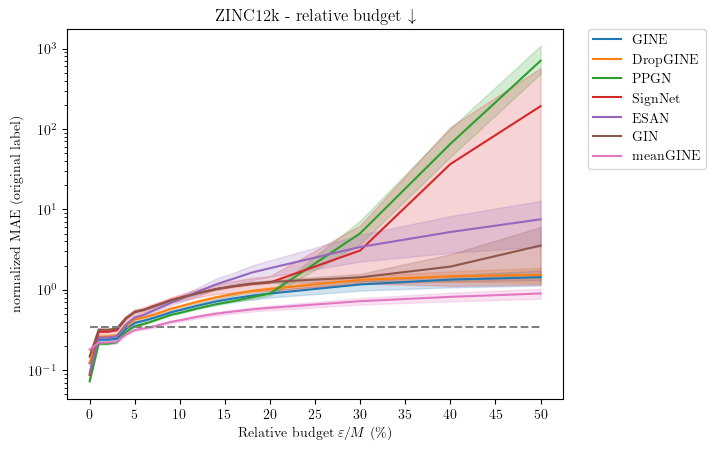

In [98]:
## ADJACENCY - REL
adjrdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["add_rdm_undir_edges_rel", "drop_rdm_undir_edges_rel"])]).copy()
adjrmd_per_model = group(adjrdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(adjrmd_per_model)

adjrmd_per_model = pd.concat([adjrmd_per_model, orig_per_model]).reset_index()
adjrmd_per_model = remove_unused_categories(adjrmd_per_model[adjrmd_per_model["model_type"]!="Baseline"])
adjrmd_per_model = rename_col(adjrmd_per_model, "model_type", "model type")

plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="norm_mae", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (baseline_value, baseline_value), color='gray', linestyle="--")
plt.title("ZINC12k - relative budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([5*i/100 for i in range(11)])
plot.set_xticklabels([f"{5*i}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('normalized MAE (original label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_rdmadj_rel.pgf"), bbox_inches='tight')

AAB_orig_df = compute_baseline_score(adjrmd_per_model, baseline_value, "norm_mae", below=False)
AAB_orig_df["norm_mae"] = 100*AAB_orig_df["norm_mae"]
# AAB_recomp_df = compute_baseline_score(adjrmd_per_model, baseline_value, "norm_mae_", below=False)
# AAB_recomp_df["norm_mae_"] = 100*AAB_recomp_df["norm_mae_"]
# AAB_df = AAB_orig_df.merge(AAB_recomp_df[["model", "norm_mae_"]], on="model")
groupby_to_table(AAB_orig_df[["model_type", "norm_mae"]].groupby("model_type"))

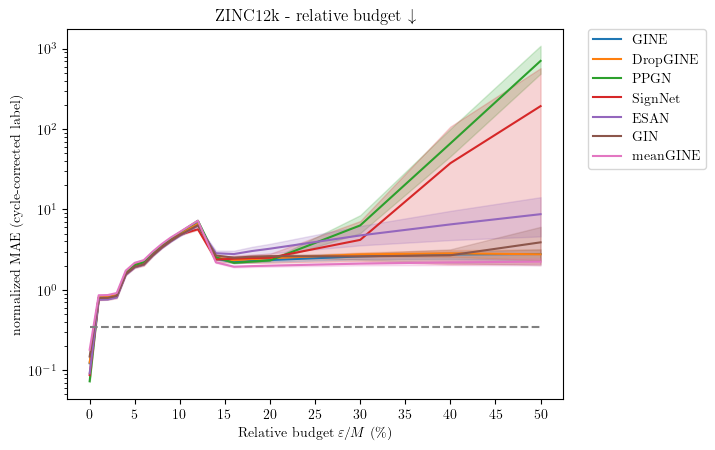

In [99]:
plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="norm_mae_", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (baseline_value, baseline_value), color='gray', linestyle="--")
plt.title("ZINC12k - relative budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([5*i/100 for i in range(11)])
plot.set_xticklabels([f"{5*i}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('normalized MAE (cycle-corrected label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_rdmadj_recomp_rel.pgf"), bbox_inches='tight')

,model_type,norm_mae
0,DropGINE,$0.763 \pm 0.055$
1,ESAN,$0.912 \pm 0.061$
2,GIN,$0.629 \pm 0.021$
3,GINE,$0.766 \pm 0.044$
4,PPGN,$1.05 \pm 0.029$
5,SignNet,$1.0 \pm 0.061$
6,meanGINE,$0.526 \pm 0.018$


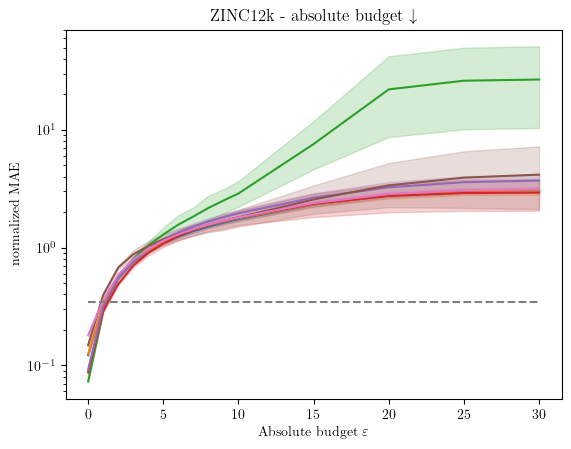

In [100]:
## FEATURES - ABS
attrrdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rdm_node_attr_change_abs", "rdm_edge_attr_change_abs"])]).copy()
attrrdm_abs_data = attrrdm_abs_data[attrrdm_abs_data["budget"]<=30]
attrrmd_per_model = group(attrrdm_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(attrrmd_per_model)

attrrmd_per_model = pd.concat([attrrmd_per_model, orig_per_model]).reset_index()
attrrmd_per_model = remove_unused_categories(attrrmd_per_model[attrrmd_per_model["model_type"]!="Baseline"])
attrrmd_per_model = rename_col(attrrmd_per_model, "model_type", "model type")

plot = sns.lineplot(data=attrrmd_per_model, x='budget', y="norm_mae", hue="model type", palette=palette)
plt.plot((0, max(attrrmd_per_model["budget"])), (baseline_value, baseline_value), color='gray', linestyle="--")
plt.title("ZINC12k - absolute budget $\\downarrow$")
plot.set_xticks([i*5 for i in range(7)])
plt.yscale('log')
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('normalized MAE')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_rdmattr_abs.pgf"), bbox_inches='tight')

AAB_orig_df = compute_baseline_score(attrrmd_per_model, baseline_value, "norm_mae", below=False)
AAB_orig_df["norm_mae"] = 100*AAB_orig_df["norm_mae"]
groupby_to_table(AAB_orig_df[["model_type", "norm_mae"]].groupby("model_type"))

,model_type,norm_mae
0,DropGINE,$0.522 \pm 0.086$
1,ESAN,$0.659 \pm 0.09$
2,GIN,$0.382 \pm 0.013$
3,GINE,$0.511 \pm 0.056$
4,PPGN,$0.834 \pm 0.052$
5,SignNet,$0.798 \pm 0.077$
6,meanGINE,$0.32 \pm 0.011$


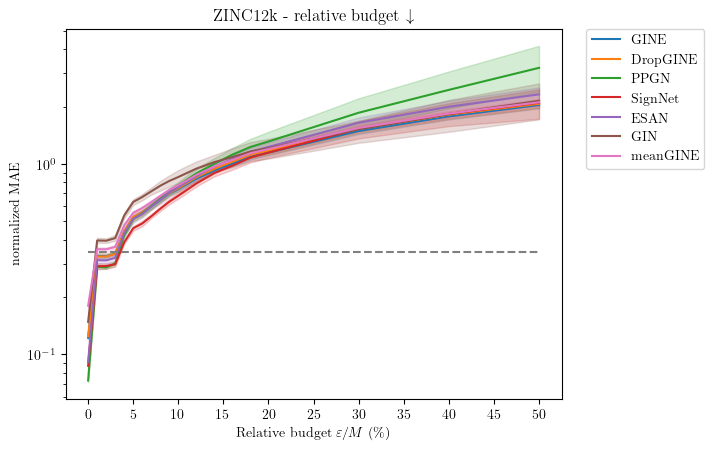

In [101]:
## FEATURES - REL
attrrdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rdm_node_attr_change_rel", "rdm_edge_attr_change_rel"])]).copy()
attrrmd_per_model = group(attrrdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(attrrmd_per_model)

attrrmd_per_model = pd.concat([attrrmd_per_model, orig_per_model]).reset_index()
attrrmd_per_model = remove_unused_categories(attrrmd_per_model[attrrmd_per_model["model_type"]!="Baseline"])
attrrmd_per_model = rename_col(attrrmd_per_model, "model_type", "model type")

plot = sns.lineplot(data=attrrmd_per_model, x='budget', y="norm_mae", hue="model type", palette=palette)
plt.plot((0, max(attrrmd_per_model["budget"])), (baseline_value, baseline_value), color='gray', linestyle="--")
plt.title("ZINC12k - relative budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([5*i/100 for i in range(11)])
plot.set_xticklabels([f"{5*i}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('normalized MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_rdmattr_rel.pgf"), bbox_inches='tight')

AAB_orig_df = compute_baseline_score(attrrmd_per_model, baseline_value, "norm_mae", below=False)
AAB_orig_df["norm_mae"] = 100*AAB_orig_df["norm_mae"]
groupby_to_table(AAB_orig_df[["model_type", "norm_mae"]].groupby("model_type"))

,model_type,norm_mae
0,DropGINE,$0.968 \pm 0.066$
1,ESAN,$1.178 \pm 0.069$
2,GIN,$0.709 \pm 0.05$
3,GINE,$1.031 \pm 0.038$
4,PPGN,$1.156 \pm 0.033$
5,SignNet,$0.897 \pm 0.118$
6,meanGINE,$0.878 \pm 0.053$


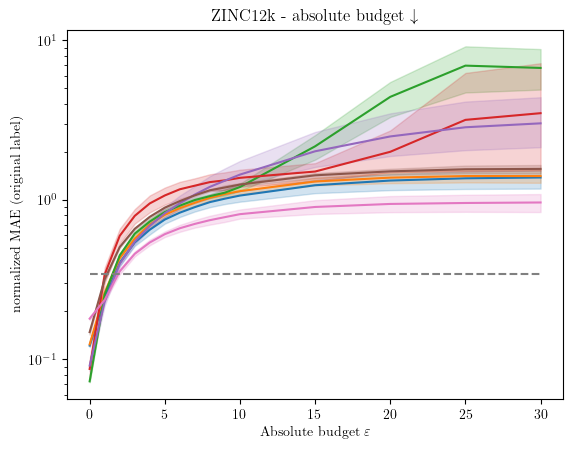

In [102]:
## REWIRE - ABS
rewirerdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rewire_rdm_undir_edges_abs"])]).copy()
rewirerdm_abs_data = rewirerdm_abs_data[rewirerdm_abs_data["budget"]<=30]
rewirermd_per_model = group(rewirerdm_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(rewirermd_per_model)

rewirermd_per_model = pd.concat([rewirermd_per_model, orig_per_model]).reset_index()
rewirermd_per_model = remove_unused_categories(rewirermd_per_model[rewirermd_per_model["model_type"]!="Baseline"])
rewirermd_per_model = rename_col(rewirermd_per_model, "model_type", "model type")

plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="norm_mae", hue="model type", palette=palette)
plt.plot((0, max(rewirermd_per_model["budget"])), (baseline_value, baseline_value), color='gray', linestyle="--")
plt.title("ZINC12k - absolute budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([i*5 for i in range(7)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('normalized MAE (original label)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_rdmrewire_abs.pgf"), bbox_inches='tight')

AAB_orig_df = compute_baseline_score(rewirermd_per_model, baseline_value, "norm_mae", below=False)
AAB_orig_df["norm_mae"] = 100*AAB_orig_df["norm_mae"]
groupby_to_table(AAB_orig_df[["model_type", "norm_mae"]].groupby("model_type"))

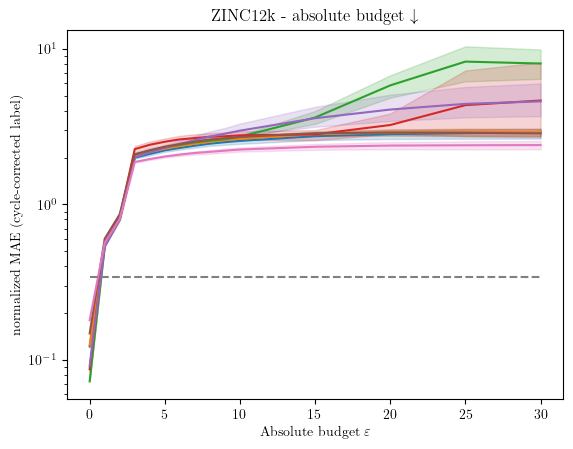

In [103]:
plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="norm_mae_", hue="model type", palette=palette)
plt.plot((0, max(rewirermd_per_model["budget"])), (baseline_value, baseline_value), color='gray', linestyle="--")
plt.title("ZINC12k - absolute budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([i*5 for i in range(7)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('normalized MAE (cycle-corrected label)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_rdmrewire_recomp_abs.pgf"), bbox_inches='tight')

,model_type,norm_mae
0,DropGINE,$0.894 \pm 0.121$
1,ESAN,$1.208 \pm 0.124$
2,GIN,$0.522 \pm 0.052$
3,GINE,$1.032 \pm 0.102$
4,PPGN,$1.028 \pm 0.046$
5,SignNet,$0.631 \pm 0.188$
6,meanGINE,$1.015 \pm 0.105$


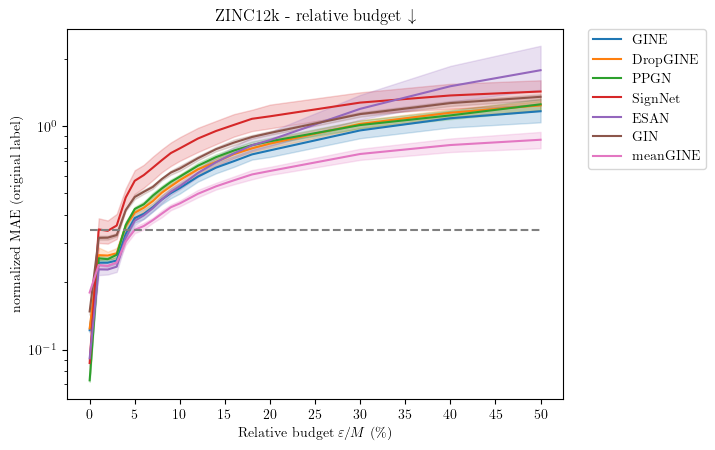

In [104]:
## REWIRE - REL
rewirerdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rewire_rdm_undir_edges_rel"])]).copy()
rewirermd_per_model = group(rewirerdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(rewirermd_per_model)

rewirermd_per_model = pd.concat([rewirermd_per_model, orig_per_model]).reset_index()
rewirermd_per_model = remove_unused_categories(rewirermd_per_model[rewirermd_per_model["model_type"]!="Baseline"])
rewirermd_per_model = rename_col(rewirermd_per_model, "model_type", "model type")

plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="norm_mae", hue="model type", palette=palette)
plt.plot((0, max(rewirermd_per_model["budget"])), (baseline_value, baseline_value), color='gray', linestyle="--")
plt.title("ZINC12k - relative budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([5*i/100 for i in range(11)])
plot.set_xticklabels([f"{5*i}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('normalized MAE (original label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_rdmrewire_rel.pgf"), bbox_inches='tight')

AAB_orig_df = compute_baseline_score(rewirermd_per_model, baseline_value, "norm_mae", below=False)
AAB_orig_df["norm_mae"] = 100*AAB_orig_df["norm_mae"]
groupby_to_table(AAB_orig_df[["model_type", "norm_mae"]].groupby("model_type"))

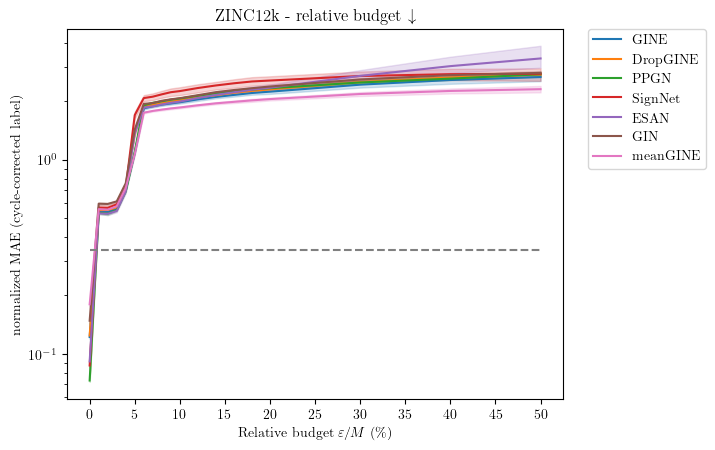

In [105]:
plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="norm_mae_", hue="model type", palette=palette)
plt.plot((0, max(rewirermd_per_model["budget"])), (baseline_value, baseline_value), color='gray', linestyle="--")
plt.title("ZINC12k - relative budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([5*i/100 for i in range(11)])
plot.set_xticklabels([f"{5*i}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('normalized MAE (cycle-corrected label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_rdmrewire_recomp_rel.pgf"), bbox_inches='tight')

## AdjPGD

In [118]:
from plots import remove_unused_categories

adjpgd_data = load_data(all_tasks, "ZINC12k", ["adjpgd"])

# norm data
adjpgd_data["norm_y"] = (adjpgd_data["y"] - y_mean) / y_std
adjpgd_data["norm_pred"] = (adjpgd_data["pred"] - y_mean) / y_std
compute_regression_metrics(adjpgd_data, y_col="norm_y", pred_col="norm_pred", mae_col="norm_mae")

# recompute label
adjpgd_data = recompute_label(adjpgd_data)
adjpgd_data["norm_y_"] = (adjpgd_data["y_"] - y_mean) / y_std
compute_regression_metrics(adjpgd_data, y_col="norm_y_", pred_col="norm_pred", mae_col="norm_mae_")

pd.pivot_table(adjpgd_data, index=["task"], columns="model_type", aggfunc="count")["y"] # each entry should have 5*5*3*1000=75000 values

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 277.20it/s]


model_type,DropGINE,ESAN,GIN,GINE,PPGN,SignNet,meanGINE
task,,,,,,,
adjpgd_abs_incr,75000,75000,75000,75000,75000,75000,75000
adjpgd_rel_incr,75000,75000,75000,75000,75000,75000,75000
adjpgd_abs_decr,75000,75000,75000,75000,75000,75000,75000
adjpgd_rel_decr,75000,75000,75000,75000,75000,75000,75000


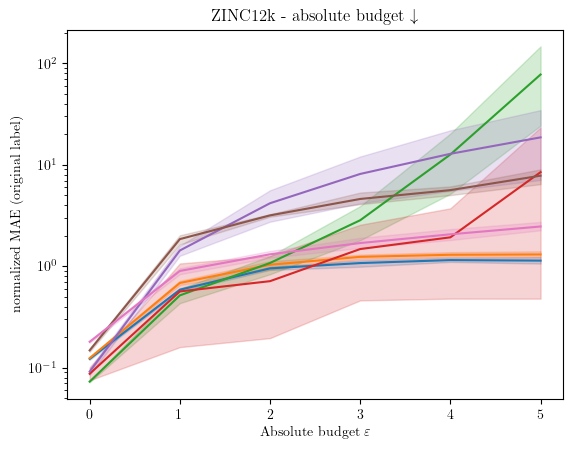

In [119]:
## ABSOLUTE BUDGET
adjpgd_abs_data = remove_unused_categories(adjpgd_data[adjpgd_data["task"].isin(["adjpgd_abs_incr", "adjpgd_abs_decr"])]).copy()

# aggregate over adj perturbations and tasks
adjpgd_abs_agg = aggregate_over_splits(adjpgd_abs_data, group_by=adjpgd_abs_data["task"], shared_cols=["model", "id", "budget", "repeat"], target_col="norm_mae")
adjpgd_abs_agg = aggregate_over_splits(adjpgd_abs_agg, group_by=adjpgd_abs_agg["repeat"], shared_cols=["model", "id", "budget"], target_col="norm_mae")
adjpgd_abs_agg["task_type"] = "adj_pgd_abs"

groupby = adjpgd_abs_agg["model"].astype(str) + adjpgd_abs_agg["budget"].astype(str)
adjpgd_abs_agg = remove_top_percentage(adjpgd_abs_agg, 0.05, ["mae", "norm_mae"], groupby)

per_model = group(adjpgd_abs_agg, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)
groupby_to_table(per_model[["model_type", "budget", "mae", "norm_mae"]].groupby(by=["model_type", "budget"]))

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")

plot = sns.lineplot(data=per_model, x='budget', y="norm_mae", hue="model type", palette=palette)
plt.title("ZINC12k - absolute budget $\\downarrow$")
plot.set_xticks([i for i in range(6)])
plt.yscale('log')
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('normalized MAE (original label)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_AdjPDG_abs.pgf"), bbox_inches='tight')

# table = pd.pivot_table(adjpgd_abs_agg, index=["perturbation"], columns="model_type", aggfunc="count")["y"] / 25000
# table = table[["meanGINE", "GIN", "GINE", "SignNet", "DropGINE", "ESAN", "PPGN"]]
# table.style.format('{:,.1%}'.format)

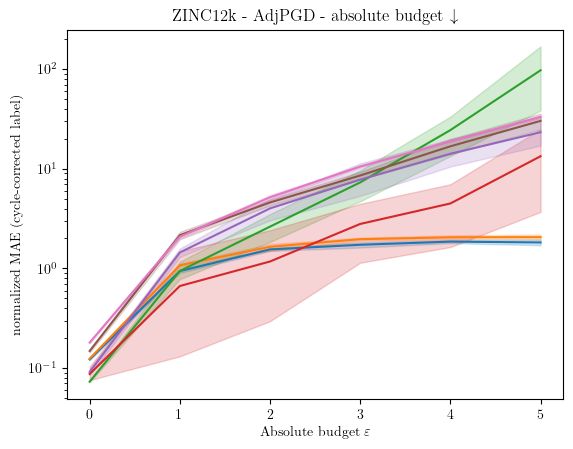

In [120]:
## ABSOLUTE BUDGET - recomputed
adjpgd_abs_data = remove_unused_categories(adjpgd_data[adjpgd_data["task"].isin(["adjpgd_abs_incr", "adjpgd_abs_decr"])]).copy()

# aggregate over adj perturbations and tasks
adjpgd_abs_agg = aggregate_over_splits(adjpgd_abs_data, group_by=adjpgd_abs_data["task"], shared_cols=["model", "id", "budget", "repeat"], target_col="norm_mae_")
adjpgd_abs_agg = aggregate_over_splits(adjpgd_abs_agg, group_by=adjpgd_abs_agg["repeat"], shared_cols=["model", "id", "budget"], target_col="norm_mae_")
adjpgd_abs_agg["task_type"] = "adj_pgd_abs"

groupby = adjpgd_abs_agg["model"].astype(str) + adjpgd_abs_agg["budget"].astype(str)
adjpgd_abs_agg = remove_top_percentage(adjpgd_abs_agg, 0.05, ["norm_mae_"], groupby)

per_model = group(adjpgd_abs_agg, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)
# groupby_to_table(per_model[["model_type", "budget", "norm_mae_"]].groupby(by=["model_type", "budget"]))

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")

plot = sns.lineplot(data=per_model, x='budget', y="norm_mae_", hue="model type", palette=palette)
plt.title("ZINC12k - AdjPGD - absolute budget $\\downarrow$")
plot.set_xticks([i for i in range(6)])
plt.yscale('log')
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('normalized MAE (cycle-corrected label)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_AdjPDG_recomp_abs.pgf"), bbox_inches='tight')

# table = pd.pivot_table(adjpgd_abs_agg, index=["perturbation"], columns="model_type", aggfunc="count")["y"] / 25000
# table = table[["meanGINE", "GIN", "GINE", "SignNet", "DropGINE", "ESAN", "PPGN"]]
# table.style.format('{:,.1%}'.format)

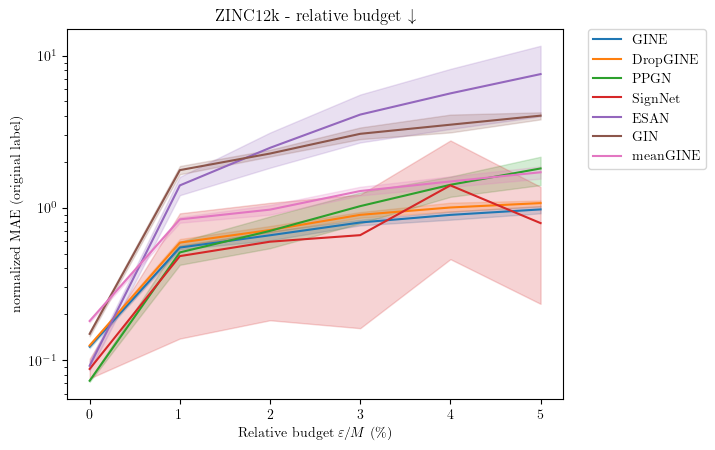

In [121]:
## RELATIVE BUDGET
adjpgd_rel_data = remove_unused_categories(adjpgd_data[adjpgd_data["task"].isin(["adjpgd_rel_incr", "adjpgd_rel_decr"])]).copy()

# aggregate over adj perturbations and tasks
adjpgd_rel_agg = aggregate_over_splits(adjpgd_rel_data, group_by=adjpgd_rel_data["task"], shared_cols=["model", "id", "budget", "repeat"], target_col="norm_mae")
adjpgd_rel_agg = aggregate_over_splits(adjpgd_rel_agg, group_by=adjpgd_rel_agg["repeat"], shared_cols=["model", "id", "budget"], target_col="norm_mae")
adjpgd_rel_agg["task_type"] = "adj_pgd_rel"

groupby = adjpgd_rel_agg["model"].astype(str) + adjpgd_rel_agg["budget"].astype(str)
adjpgd_rel_agg = remove_top_percentage(adjpgd_rel_agg, 0.05, ["mae", "norm_mae"], groupby)

per_model = group(adjpgd_rel_agg, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)
groupby_to_table(per_model[["model_type", "budget", "mae", "norm_mae"]].groupby(by=["model_type", "budget"]))

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")

plot = sns.lineplot(data=per_model, x='budget', y="norm_mae", hue="model type", palette=palette)
plt.title("ZINC12k - relative budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([i/100 for i in range(6)])
plot.set_xticklabels([f"{i}" for i in range(6)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('normalized MAE (original label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plot.figure.savefig(osp.join(plots_dir, "ZINC12k_AdjPDG_rel.pgf"), bbox_inches='tight')

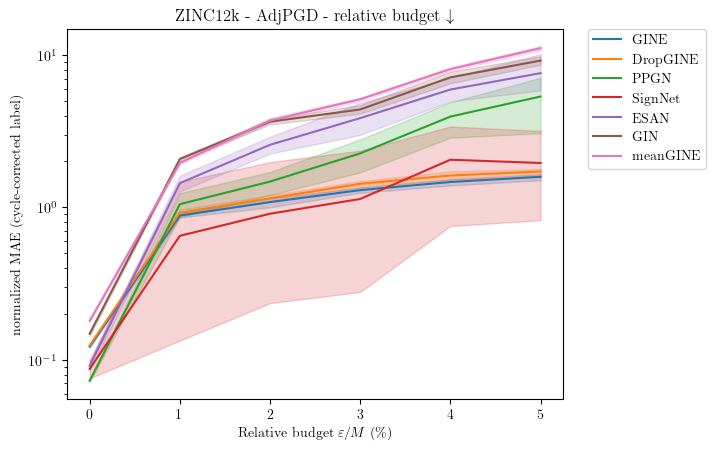

In [122]:
## RELATIVE BUDGET
adjpgd_rel_data = remove_unused_categories(adjpgd_data[adjpgd_data["task"].isin(["adjpgd_rel_incr", "adjpgd_rel_decr"])]).copy()

# aggregate over adj perturbations and tasks
adjpgd_rel_agg = aggregate_over_splits(adjpgd_rel_data, group_by=adjpgd_rel_data["task"], shared_cols=["model", "id", "budget", "repeat"], target_col="norm_mae_")
adjpgd_rel_agg = aggregate_over_splits(adjpgd_rel_agg, group_by=adjpgd_rel_agg["repeat"], shared_cols=["model", "id", "budget"], target_col="norm_mae_")
adjpgd_rel_agg["task_type"] = "adj_pgd_rel"

groupby = adjpgd_rel_agg["model"].astype(str) + adjpgd_rel_agg["budget"].astype(str)
adjpgd_rel_agg = remove_top_percentage(adjpgd_rel_agg, 0.05, ["norm_mae_"], groupby)

per_model = group(adjpgd_rel_agg, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)
# groupby_to_table(per_model[["model_type", "budget", "mae", "norm_mae_"]].groupby(by=["model_type", "budget"]))

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")

plot = sns.lineplot(data=per_model, x='budget', y="norm_mae_", hue="model type", palette=palette)
plt.title("ZINC12k - AdjPGD - relative budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([i/100 for i in range(6)])
plot.set_xticklabels([f"{i}" for i in range(6)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('normalized MAE (cycle-corrected label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plot.figure.savefig(osp.join(plots_dir, "ZINC12k_AdjPDG_recomp_rel.pgf"), bbox_inches='tight')

## AttrPGD

In [123]:
from plots import remove_unused_categories

attrpgd_data = load_data(all_tasks, "ZINC12k", ["attrpgd"], sortby=["model", "task", "id", "budget"])

attrpgd_data["norm_y"] = (attrpgd_data["y"] - y_mean) / y_std
attrpgd_data["norm_pred"] = (attrpgd_data["pred"] - y_mean) / y_std
compute_regression_metrics(attrpgd_data, y_col="norm_y", pred_col="norm_pred", mae_col="norm_mae")

# recompute label
attrpgd_data = recompute_label(attrpgd_data)
attrpgd_data["norm_y_"] = (attrpgd_data["y_"] - y_mean) / y_std
compute_regression_metrics(attrpgd_data, y_col="norm_y_", pred_col="norm_pred", mae_col="norm_mae_")

pd.set_option('display.max_columns', 500)
pd.pivot_table(attrpgd_data, index=["task"], columns="model_type", aggfunc="count")["y"] # each entry should have 5*5*1000=25000 values 

100%|██████████| 40/40 [00:00<00:00, 348.85it/s]

model_type,DropGINE,ESAN,GIN,GINE,PPGN,SignNet,meanGINE
task,,,,,,,
attrpgd_abs_incr,25000,25000,25000,25000,25000,25000,25000
attrpgd_rel_incr,25000,25000,25000,25000,25000,25000,25000
attrpgd_abs_decr,25000,25000,25000,25000,25000,25000,25000
attrpgd_rel_decr,25000,25000,25000,25000,25000,25000,25000


model_type,DropGINE,ESAN,GIN,GINE,PPGN,SignNet,meanGINE
task,,,,,,,
attrpgd_abs_incr,0.03752,0.04384,0.10732,0.03356,0.14928,0.11048,0.03392
attrpgd_abs_decr,0.91248,0.90616,0.84268,0.91644,0.80072,0.83952,0.91608


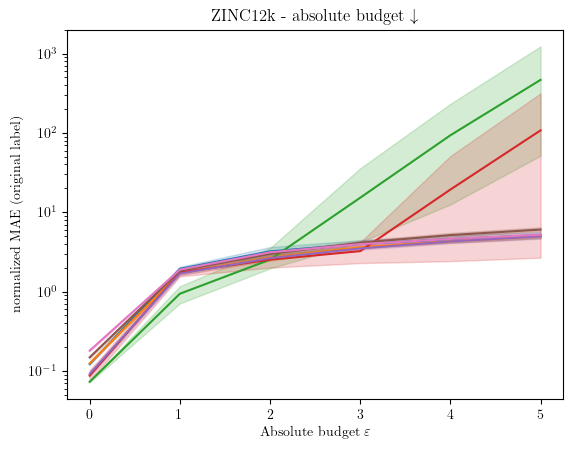

In [124]:
## ABSOLUTE BUDGET
attrpgd_abs_data = remove_unused_categories(attrpgd_data[attrpgd_data["task"].isin(["attrpgd_abs_incr", "attrpgd_abs_decr"])]).copy()

# aggregate over attr perturbations and tasks
attrpgd_abs_agg = aggregate_over_splits(attrpgd_abs_data, group_by=attrpgd_abs_data["task"], shared_cols=["model", "id", "budget"], target_col="norm_mae")
attrpgd_abs_agg["task_type"] = "attr_pgd_abs"

groupby = attrpgd_abs_agg["model"].astype(str) + attrpgd_abs_agg["budget"].astype(str)
attrpgd_abs_agg = remove_top_percentage(attrpgd_abs_agg, 0.05, ["mae", "norm_mae"], groupby)

per_model = group(attrpgd_abs_agg, ["model", "budget"]).mean().reset_index()
per_model = pd.concat([per_model, orig_per_model]).reset_index()
append_model_type(per_model)
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")

plot = sns.lineplot(data=per_model, x='budget', y="norm_mae", hue="model type", palette=palette)
plt.title("ZINC12k - absolute budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([i for i in range(6)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('normalized MAE (original label)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_AttrPGD_abs.pgf"), bbox_inches='tight')

pd.pivot_table(attrpgd_abs_agg, index=["task"], columns="model_type", aggfunc="count")["y"] / 25000

model_type,DropGINE,ESAN,GIN,GINE,PPGN,SignNet,meanGINE
task,,,,,,,
attrpgd_abs_incr,0.02992,0.03504,0.2264,0.02884,0.229,0.30644,0.04528
attrpgd_abs_decr,0.92008,0.91496,0.7236,0.92116,0.721,0.64356,0.90472


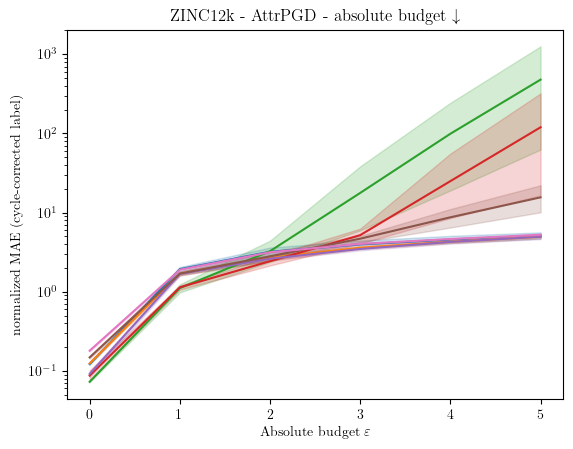

In [125]:
## ABSOLUTE BUDGET
attrpgd_abs_data = remove_unused_categories(attrpgd_data[attrpgd_data["task"].isin(["attrpgd_abs_incr", "attrpgd_abs_decr"])]).copy()

# aggregate over attr perturbations and tasks
attrpgd_abs_agg = aggregate_over_splits(attrpgd_abs_data, group_by=attrpgd_abs_data["task"], shared_cols=["model", "id", "budget"], target_col="norm_mae_")
attrpgd_abs_agg["task_type"] = "attr_pgd_abs"

groupby = attrpgd_abs_agg["model"].astype(str) + attrpgd_abs_agg["budget"].astype(str)
attrpgd_abs_agg = remove_top_percentage(attrpgd_abs_agg, 0.05, ["norm_mae_"], groupby)

per_model = group(attrpgd_abs_agg, ["model", "budget"]).mean().reset_index()
per_model = pd.concat([per_model, orig_per_model]).reset_index()
append_model_type(per_model)
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")

plot = sns.lineplot(data=per_model, x='budget', y="norm_mae_", hue="model type", palette=palette)
plt.title("ZINC12k - AttrPGD - absolute budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([i for i in range(6)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('normalized MAE (cycle-corrected label)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_AttrPGD_recomp_abs.pgf"), bbox_inches='tight')

pd.pivot_table(attrpgd_abs_agg, index=["task"], columns="model_type", aggfunc="count")["y"] / 25000

model_type,DropGINE,ESAN,GIN,GINE,PPGN,SignNet,meanGINE
task,,,,,,,
attrpgd_rel_incr,0.06236,0.088,0.07932,0.0568,0.10688,0.09708,0.05944
attrpgd_rel_decr,0.88764,0.862,0.87068,0.8932,0.84312,0.85292,0.89056


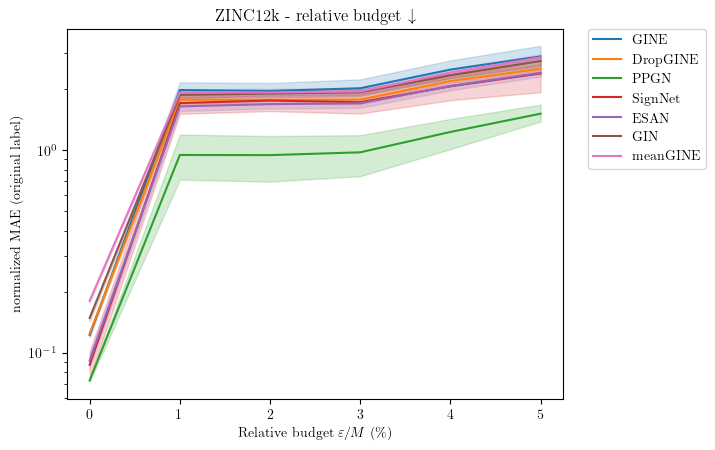

In [126]:
## RELATIVE BUDGET
attrpgd_rel_data = remove_unused_categories(attrpgd_data[attrpgd_data["task"].isin(["attrpgd_rel_incr", "attrpgd_rel_decr"])]).copy()

# aggregate over attr perturbations and tasks
attrpgd_rel_agg = aggregate_over_splits(attrpgd_rel_data, group_by=attrpgd_rel_data["task"], shared_cols=["model", "id", "budget"], target_col="norm_mae")
attrpgd_rel_agg["task_type"] = "attr_pgd_rel"

groupby = attrpgd_rel_agg["model"].astype(str) + attrpgd_rel_agg["budget"].astype(str)
attrpgd_rel_agg = remove_top_percentage(attrpgd_rel_agg, 0.05, ["mae", "norm_mae"], groupby)

per_model = group(attrpgd_rel_agg, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)
per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")

plot = sns.lineplot(data=per_model, x='budget', y="norm_mae", hue="model type", palette=palette)
plt.title("ZINC12k - relative budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([i/100 for i in range(6)])
plot.set_xticklabels([f"{i}" for i in range(6)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('normalized MAE (original label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_AttrPGD_rel.pgf"), bbox_inches='tight')

pd.pivot_table(attrpgd_rel_agg, index=["task"], columns="model_type", aggfunc="count")["y"] / 25000

model_type,DropGINE,ESAN,GIN,GINE,PPGN,SignNet,meanGINE
task,,,,,,,
attrpgd_rel_incr,0.05724,0.08076,0.14516,0.05444,0.19784,0.2724,0.06456
attrpgd_rel_decr,0.89276,0.86924,0.80480,0.89556,0.75216,0.6776,0.88544


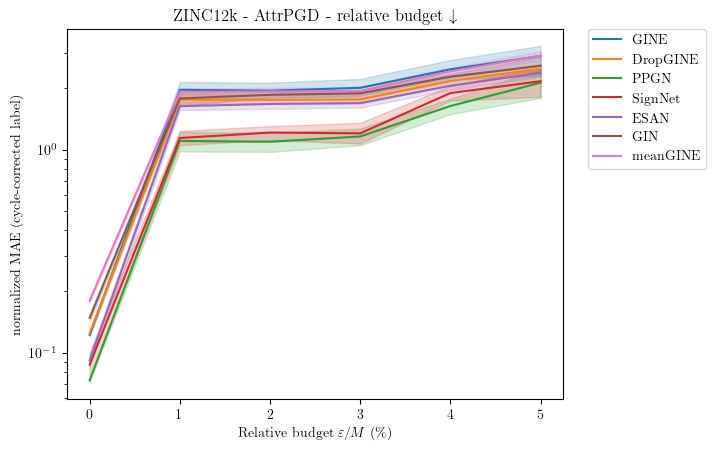

In [127]:
## RELATIVE BUDGET - recomputed
attrpgd_rel_data = remove_unused_categories(attrpgd_data[attrpgd_data["task"].isin(["attrpgd_rel_incr", "attrpgd_rel_decr"])]).copy()

# aggregate over attr perturbations and tasks
attrpgd_rel_agg = aggregate_over_splits(attrpgd_rel_data, group_by=attrpgd_rel_data["task"], shared_cols=["model", "id", "budget"], target_col="norm_mae_")
attrpgd_rel_agg["task_type"] = "attr_pgd_rel"

groupby = attrpgd_rel_agg["model"].astype(str) + attrpgd_rel_agg["budget"].astype(str)
attrpgd_rel_agg = remove_top_percentage(attrpgd_rel_agg, 0.05, ["norm_mae_"], groupby)

per_model = group(attrpgd_rel_agg, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)
per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")

plot = sns.lineplot(data=per_model, x='budget', y="norm_mae_", hue="model type", palette=palette)
plt.title("ZINC12k - AttrPGD - relative budget $\\downarrow$")
plt.yscale('log')
plot.set_xticks([i/100 for i in range(6)])
plot.set_xticklabels([f"{i}" for i in range(6)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('normalized MAE (cycle-corrected label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "ZINC12k_AttrPGD_recomp_rel.pgf"), bbox_inches='tight')

pd.pivot_table(attrpgd_rel_agg, index=["task"], columns="model_type", aggfunc="count")["y"] / 25000

## Comparison between PGD and BruteForce

In [116]:
## ADJACENCY COMPARISON
adjpgd_abs_data = remove_unused_categories(adjpgd_data[adjpgd_data["task"].isin(["adjpgd_abs_incr", "adjpgd_abs_decr"])]).copy()
adjpgd_abs_agg = aggregate_over_splits(adjpgd_abs_data, group_by=adjpgd_abs_data["task"], shared_cols=["model", "id", "budget"], target_col="norm_mae")
adjpgd_abs_agg = aggregate_over_splits(adjpgd_abs_agg, group_by=adjpgd_abs_agg["repeat"], shared_cols=["model", "id", "budget"], target_col="norm_mae")
adjpgd_abs_agg["task_type"] = "adj_pgd_abs"
adjpgd_df = adjpgd_abs_agg[adjpgd_abs_agg["budget"]==1][["model", "id", "mae", "norm_mae", "pred"]].rename(columns={'mae': 'pgd_mae', 'norm_mae': 'pgd_norm_mae'})

adjbf_data = remove_unused_categories(adjbf_data[adjbf_data["perturbation"].isin(["add-edge", "drop-edge"])]).copy()
adjbf_agg = aggregate_over_splits(adjbf_data, group_by=adjbf_data["task"], shared_cols=["model", "id", "perturbation"], target_col="norm_mae")
adjbf_agg = aggregate_over_splits(adjbf_agg, group_by=adjbf_agg["perturbation"], shared_cols=["model", "id"], target_col="norm_mae")
adjbf_agg["task_type"] = "bf"
bf_df = adjbf_agg[["model", "id", "mae", "norm_mae", "pred"]].rename(columns={'mae': 'bf_mae', 'norm_mae': 'bf_norm_mae'})

adj_comparison_df = adjpgd_df.merge(bf_df, on=["model", "id"])
append_model_type(adj_comparison_df)
adj_comparison_df["close"] = np.isclose(adj_comparison_df["pgd_mae"], adj_comparison_df["bf_mae"], rtol=1e-03)
adj_comparison_df["better"] = adj_comparison_df["pgd_mae"] > adj_comparison_df["bf_mae"] - 1e-05

print(adj_comparison_df.groupby(by="model_type").count()["id"])

per_model = group(adj_comparison_df, ["model"]).mean().reset_index()
per_model["relative_mae"] = per_model["pgd_mae"] / per_model["bf_mae"]
append_model_type(per_model)
groupby_to_table(per_model[["model_type", "relative_mae", "better"]].groupby("model_type"))

model_type
DropGINE    5000
ESAN        5000
GIN         5000
GINE        5000
PPGN        5000
SignNet     5000
meanGINE    5000
Name: id, dtype: int64


,model_type,relative_mae,better
0,DropGINE,$0.502 \pm 0.06$,$0.106 \pm 0.024$
1,ESAN,$0.773 \pm 0.066$,$0.341 \pm 0.061$
2,GIN,$0.682 \pm 0.082$,$0.431 \pm 0.094$
3,GINE,$0.415 \pm 0.034$,$0.069 \pm 0.015$
4,PPGN,$0.16 \pm 0.099$,$0.03 \pm 0.027$
5,SignNet,$0.318 \pm 0.34$,$0.19 \pm 0.269$
6,meanGINE,$0.801 \pm 0.049$,$0.327 \pm 0.074$


In [117]:
## ATTRIBUTE COMPARISON
attrpgd_abs_data = remove_unused_categories(attrpgd_data[attrpgd_data["task"].isin(["attrpgd_abs_incr", "attrpgd_abs_decr"])]).copy()
attrpgd_abs_agg = aggregate_over_splits(attrpgd_abs_data, group_by=attrpgd_abs_data["task"], shared_cols=["model", "id", "budget"], target_col="norm_mae")
attrpgd_abs_agg["task_type"] = "attr_pgd_abs"
attrpgd_df = attrpgd_abs_agg[attrpgd_abs_agg["budget"]==1][["model", "id", "mae", "norm_mae", "pred"]].rename(columns={'mae': 'pgd_mae', 'norm_mae': 'pgd_norm_mae'})

attrbf_agg = aggregate_over_splits(attrbf_data, group_by=attrbf_data["task"], shared_cols=["model", "id", "perturbation"], target_col="norm_mae")
attrbf_agg = aggregate_over_splits(attrbf_agg, group_by=attrbf_agg["perturbation"], shared_cols=["model", "id"], target_col="norm_mae")
attrbf_agg["task_type"] = "bf"
bf_df = attrbf_agg[["model", "id", "mae", "norm_mae", "pred"]].rename(columns={'mae': 'bf_mae', 'norm_mae': 'bf_norm_mae'})

attr_comparison_df = attrpgd_df.merge(bf_df, on=["model", "id"])
append_model_type(attr_comparison_df)
attr_comparison_df["close"] = np.isclose(attr_comparison_df["pgd_mae"], attr_comparison_df["bf_mae"], rtol=1e-03)
attr_comparison_df["better"] = attr_comparison_df["pgd_mae"] > attr_comparison_df["bf_mae"] - 1e-05

print(attr_comparison_df.groupby(by="model_type").count()["id"])

per_model = group(attr_comparison_df, ["model"]).mean().reset_index()
per_model["relative_mae"] = per_model["pgd_mae"] / per_model["bf_mae"]
append_model_type(per_model)
groupby_to_table(per_model[["model_type", "relative_mae", "better"]].groupby("model_type"))

model_type
DropGINE    5000
ESAN        5000
GINE        5000
PPGN        5000
SignNet     5000
meanGINE    5000
Name: id, dtype: int64


,model_type,relative_mae,better
0,DropGINE,$0.752 \pm 0.019$,$0.196 \pm 0.028$
1,ESAN,$0.719 \pm 0.1$,$0.128 \pm 0.035$
2,GINE,$0.783 \pm 0.015$,$0.387 \pm 0.115$
3,PPGN,$0.333 \pm 0.188$,$0.042 \pm 0.032$
4,SignNet,$0.689 \pm 0.13$,$0.208 \pm 0.174$
5,meanGINE,$0.783 \pm 0.124$,$0.256 \pm 0.052$
